In [20]:
# For image data you can still describe your data by the number of classes, 
    # Number of images, 
    # plot example classes of the image, 
    # size of images, 
    # are sizes uniform? 
    # Do they need to be cropped? normalized? etc.
# https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a

In [21]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from PIL import Image


Number of Classes: 4
Total number of Images: 400


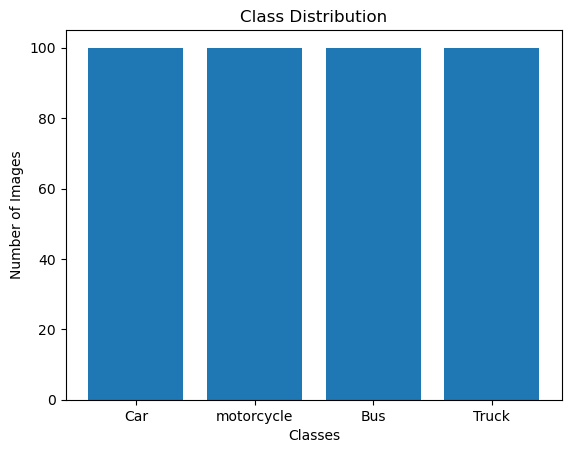

In [22]:
# Plot example classes of the image
image_dir = "Dataset"
image_classes = os.listdir(image_dir)

num_classes = len(image_classes)
num_images = sum(len(os.listdir(os.path.join(image_dir, cls))) for cls in image_classes)

print(f"Number of Classes: {num_classes}")
print(f"Total number of Images: {num_images}")

class_distribution = {cls: len(os.listdir(os.path.join(image_dir, cls))) for cls in image_classes}
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

As we see here, we have an even distribution of images within each folder for all classes

In [23]:
image_paths = []
folder_path = 'Dataset'

output_dct = {}
for vehicle in ['Bus', 'Car', 'motorcycle', 'Truck']:
    vehicle_folder = os.path.join(folder_path, vehicle)
    image_dimensions = []

    for img in os.listdir(vehicle_folder):
        img_path = os.path.join(vehicle_folder, img)

        with Image.open(img_path) as img:
            width, height = img.size
            image_dimensions.append((width, height))

    output_dct[vehicle] = image_dimensions

dimension_df = pd.DataFrame(output_dct)

In [25]:
for col in dimension_df.columns:
    num_unique = dimension_df[col].nunique()
    print(f'Number of unique image dimensions for {col}: {num_unique}')

Number of unique image dimensions for Bus: 82
Number of unique image dimensions for Car: 71
Number of unique image dimensions for motorcycle: 74
Number of unique image dimensions for Truck: 78


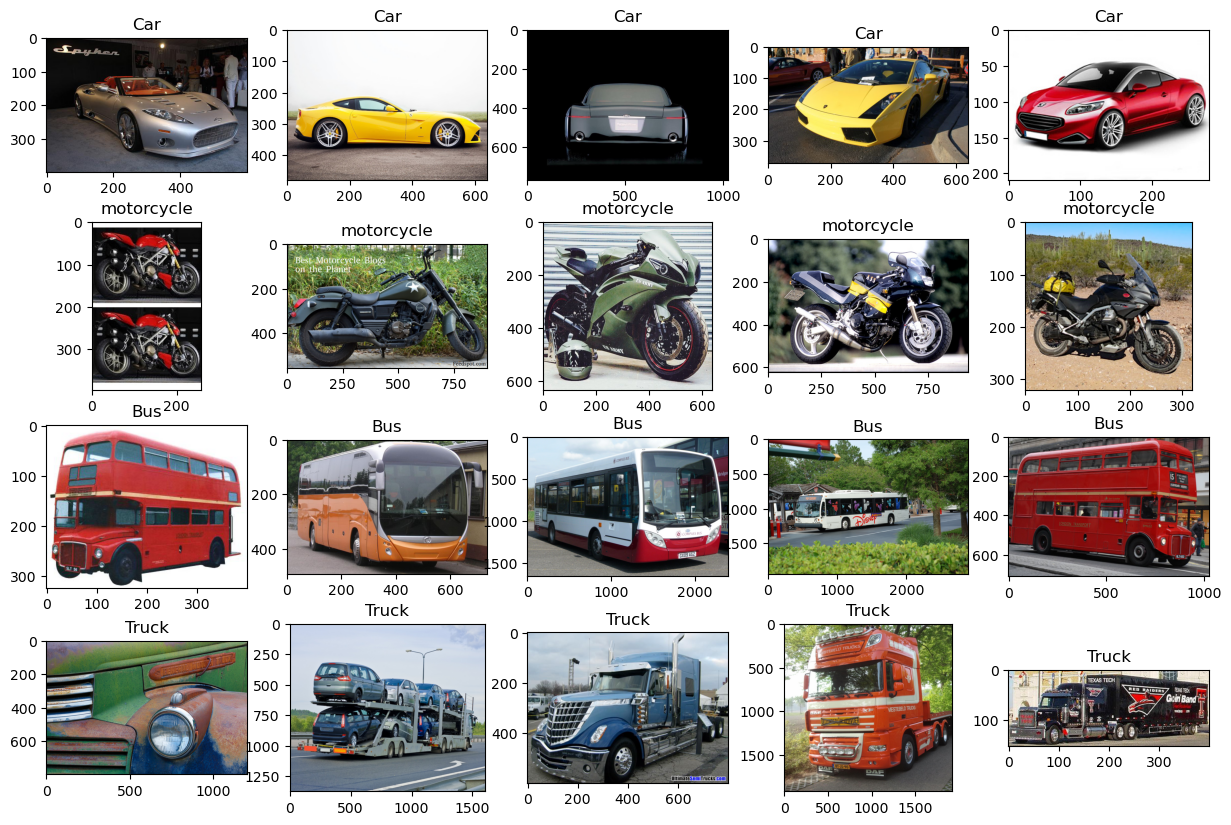

In [ ]:
# Image uniformity
image_dir = "Dataset"
image_classes = os.listdir(image_dir)
def display_samples(image_dir, num_samples=5):
    plt.figure(figsize=(15, 10))
    for cls in image_classes:
        sample_images = np.random.choice(os.listdir(os.path.join(image_dir, cls)), num_samples, replace=False)
        # print(sample_images)
        for i, img_name in enumerate(sample_images):
            img_path = os.path.join(image_dir, cls, img_name)
            img = Image.open(img_path)
            plt.subplot(len(image_classes), num_samples, i + 1 + image_classes.index(cls) * num_samples)
            plt.imshow(img)
            plt.title(cls)
    plt.show()

display_samples(image_dir)